# Load data

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as K

In [38]:
def read_data(name):
    X_train, y_train = [], []
    X_test, y_test = [], []
    X = np.load(f'data/keypoints/{name}.npy').reshape((-1, 51))
    with open(f'data/labels/{name}') as f:
        labels = f.readlines()

    N = int(re.findall(r'\d+', labels[0])[0])
    assert N == X.shape[0]

    end = 0

    for lab in labels:
        C = re.findall(r'\d:', lab)
        if len(C) == 1:
            C = int(C[0][0])

        idxs = re.findall(r'\d+-\d+', lab)
        if len(idxs) > 1:  
            print()
            print(f'Add label [{C}] to train samples')
            for idx in idxs[:-1]:
                start, stop = idx.split('-')
                start, stop = int(start), int(stop)

                X_train.append(X[end:start])
                y_train.append(0)

                X_train.append(X[start:stop])
                y_train.append(C)        
                print(idx, end='\t')

                end = stop
            
            print()
            print(f'Add label [{C}] to test samples')
            idx = idxs[-1]
            start, stop = idx.split('-')
            start, stop = int(start), int(stop)

            X_test.append(X[end:start])
            y_test.append(0)
            
            print(idx, end='\t')
            X_test.append(X[start:stop])
            y_test.append(C)        

            end = stop

    X_train.append(X[end:-1])
    y_train.append(0)
    
    return X_train, y_train, X_test, y_test

In [39]:
X_train, y_train, X_test, y_test = [], [], [], []

FILE_NAMES = ['id0_jab_1',  'id0_jab_2', 
              'id0_hook_1', 'id0_hook_2',
              'id0_uper_1', 'id0_uper_2']

for name in FILE_NAMES:
    x1, y1, x2, y2 = read_data(name)

    X_train += x1
    y_train += y1
    X_test += x2
    y_test += y2


Add label [1] to train samples
5-30	42-70	88-115	130-154	
Add label [1] to test samples
170-200	
Add label [2] to train samples
220-247	268-293	315-340	365-387	
Add label [2] to test samples
417-436	
Add label [1] to train samples
465-493	515-538	560-583	605-625	
Add label [1] to test samples
650-675	
Add label [2] to train samples
696-715	742-762	787-807	833-850	
Add label [2] to test samples
878-895	
Add label [1] to train samples
19-39	68-89	107-147	156-190	
Add label [1] to test samples
215-243	
Add label [2] to train samples
266-288	317-334	361-382	413-433	
Add label [2] to test samples
462-482	
Add label [1] to train samples
564-578	600-615	639-657	680-695	
Add label [1] to test samples
720-737	
Add label [2] to train samples
764-778	802-817	840-857	884-898	
Add label [2] to test samples
924-939	
Add label [3] to train samples
1-22	45-70	92-117	141-164	
Add label [3] to test samples
202-225	
Add label [4] to train samples
275-300	319-344	372-395	430-455	
Add label [4] to test sa

In [40]:
len(X_train), len(X_test)

(200, 48)

In [41]:
y_train = K.utils.to_categorical(y_train, num_classes=7)
X_train = tf.ragged.constant(X_train)

y_test = K.utils.to_categorical(y_test, num_classes=7)
X_test = tf.ragged.constant(X_test)

## Simple RNN 

In [58]:
inpu = K.layers.InputLayer((None, 51), batch_size=1)
rnn = K.layers.SimpleRNN(32, stateful=True)
dense1 = K.layers.Dense(64)
dense2 = K.layers.Dense(7, activation='softmax')

model = K.Sequential([inpu, rnn, dense1, dense2])

In [59]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (1, 32)                   2688      
_________________________________________________________________
dense_4 (Dense)              (1, 64)                   2112      
_________________________________________________________________
dense_5 (Dense)              (1, 7)                    455       
Total params: 5,255
Trainable params: 5,255
Non-trainable params: 0
_________________________________________________________________


In [61]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=1, epochs=50)

Epoch 1/50
200/200 [==============================] - 2s 6ms/step - loss: 1.6893 - accuracy: 0.5000 - val_loss: 1.6341 - val_accuracy: 0.5000
Epoch 2/50
200/200 [==============================] - 1s 4ms/step - loss: 1.6158 - accuracy: 0.5050 - val_loss: 1.6281 - val_accuracy: 0.5000
Epoch 3/50
200/200 [==============================] - 1s 4ms/step - loss: 1.6153 - accuracy: 0.5150 - val_loss: 1.7339 - val_accuracy: 0.5000
Epoch 4/50
200/200 [==============================] - 1s 4ms/step - loss: 1.6047 - accuracy: 0.5150 - val_loss: 1.5523 - val_accuracy: 0.5000
Epoch 5/50
200/200 [==============================] - 1s 4ms/step - loss: 1.5321 - accuracy: 0.5150 - val_loss: 1.4610 - val_accuracy: 0.5000
Epoch 6/50
200/200 [==============================] - 1s 4ms/step - loss: 1.4335 - accuracy: 0.5200 - val_loss: 1.5502 - val_accuracy: 0.4583
Epoch 7/50
200/200 [==============================] - 1s 4ms/step - loss: 1.5198 - accuracy: 0.5300 - val_loss: 1.6677 - val_accuracy: 0.5000
Epoch 

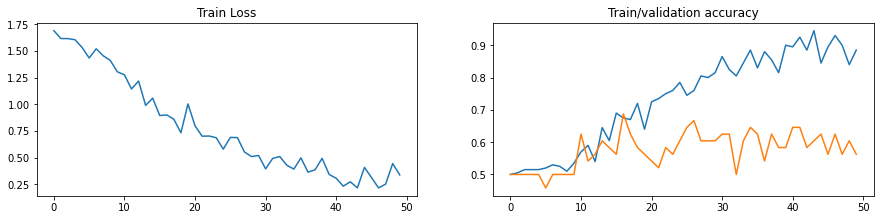

In [62]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title("Train Loss")
plt.plot(history.history['loss'])
plt.subplot(222)
plt.title("Train/validation accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

## LSTM

In [63]:
inpu = K.layers.InputLayer((None, 51), batch_size=1)
rnn = K.layers.LSTM(32, stateful=True)
dense1 = K.layers.Dense(64)
dense2 = K.layers.Dense(7, activation='softmax')

model = K.Sequential([inpu, rnn, dense1, dense2])

In [64]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [65]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 32)                   10752     
_________________________________________________________________
dense_6 (Dense)              (1, 64)                   2112      
_________________________________________________________________
dense_7 (Dense)              (1, 7)                    455       
Total params: 13,319
Trainable params: 13,319
Non-trainable params: 0
_________________________________________________________________


In [66]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=1, epochs=50)

Epoch 1/50
200/200 [==============================] - 2s 7ms/step - loss: 1.6239 - accuracy: 0.4950 - val_loss: 1.5660 - val_accuracy: 0.5000
Epoch 2/50
200/200 [==============================] - 1s 6ms/step - loss: 1.5697 - accuracy: 0.5150 - val_loss: 1.5096 - val_accuracy: 0.5000
Epoch 3/50
200/200 [==============================] - 1s 6ms/step - loss: 1.5017 - accuracy: 0.5100 - val_loss: 1.5145 - val_accuracy: 0.5000
Epoch 4/50
200/200 [==============================] - 1s 6ms/step - loss: 1.4620 - accuracy: 0.5150 - val_loss: 1.4263 - val_accuracy: 0.5000
Epoch 5/50
200/200 [==============================] - 1s 6ms/step - loss: 1.4644 - accuracy: 0.5100 - val_loss: 1.5806 - val_accuracy: 0.5000
Epoch 6/50
200/200 [==============================] - 1s 6ms/step - loss: 1.5302 - accuracy: 0.5200 - val_loss: 1.6910 - val_accuracy: 0.5000
Epoch 7/50
200/200 [==============================] - 1s 6ms/step - loss: 1.5795 - accuracy: 0.5150 - val_loss: 1.6023 - val_accuracy: 0.5000
Epoch 

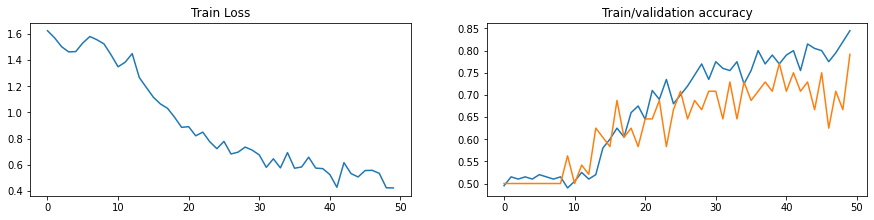

In [67]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title("Train Loss")
plt.plot(history.history['loss'])
plt.subplot(222)
plt.title("Train/validation accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])